### **ECO 518: Part II, Problem Set 2**  

* *Original Author:* Emily Merola
* *First created:* 2022.04.06
* *Last updated:* 2022.04.07
* *Collaborator:* Melissa Carleton

#### **Question 1**
##### Part (i) 
Using a normal kernel and the normal reference rule, estimate the density of log income at each value of X, where X is the log income data. Plot the estimated density of log income.

In [2]:
#Housekeeping
    #example of how to import a package below:
    #import Pkg; Pkg.add("CSV")
    using LinearAlgebra, Plots, SparseArrays, Random, Statistics, Parameters, BenchmarkTools, PiecewiseLinearApprox, Optim, XLSX, CSV, DataFrames, LinearRegression

#Load the spreadsheet of Engel data  
    engel = DataFrame(CSV.File("engel.csv"))

,foodexp,income
,Float64,Float64
1,255.839,420.158
2,310.959,541.412
3,485.68,901.158
4,402.997,639.08
5,495.561,750.876
6,633.798,945.799
7,630.757,829.398
8,700.441,979.165
9,830.959,1309.88


The *normal reference rule* assumes that the true distribution of our variable of interest (log_income) is normal.

If the Kernel function used, K(z), is also normal, then we set the badwidth to:

$$h^* = \frac{1.059\sigma}{N^{1/5}}$$

Where $\sigma^2 = Var(X)$ can be estimated in the data.

Also, we know that the estimator will be defined as:

$$\hat{f}(x_0) = \frac{1}{Nh^*}\sum_{i=1}^NK(\frac{X_i-x_0}{h^*})$$

Where $h^*$ is defined as above, and:

$$K(z) = (2\pi)^{-1/2}e^{-z^2/2}$$

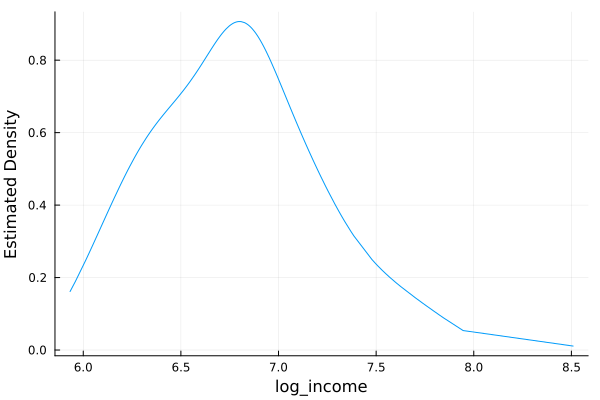

In [3]:
#Question 1, part (i)
# Generate our variable of interest
    log_income = log.(engel.income)
    engel[!, :log_income] = log_income

# Items for to creating kernel estimates
    
    #General
    N = 235                                         #number of observations
    σ = sqrt(var(engel.log_income))                 #sample sd of log_income
    hstar = (1.059*σ)/(N^(1/5))                     #optimal bandwidth implied by the normal reference rule and normal kernel

# Create a function that will take in a point from Xgrid (i.e., x0), and will output the estimated kernel density

function fhat_kernel(x0) 
        
    #breaking out into intermediate vars to make the pieces of our larger equation easier to see
    diff_0 = engel.log_income .- x0
    z_0 = diff_0 ./ hstar
    K_0 = (2π)^(-1/2) * exp.((-(z_0 .^2) / 2))
    fhat_0 = (1/(N*hstar)) * sum(K_0)

end

#add density to the dataframe:
est_density = fhat_kernel.(engel.log_income)
engel[!, :est_density] = est_density

#plot the estimated density of log_income
sort!(engel, [:log_income])
plot(engel.log_income, engel.est_density, legend = false, xlabel="log_income", ylabel="Estimated Density")

##### Part (ii) - Kernel Regression

Estimate the regression of share of food expenditures on log income (i.e. the Engel
curve) using Kernel Regression with a normal kernel in three steps:

* (a) For Kernel Regression, calculate and plot the cross-validation criterion as a function of h (the bandwidth) on the interval (0, 1] in 0.01 increments (e.g. h = 0.01, 0.02, . . . , 0.99, 1).
* (b) Approximate the optimal bandwidth $h_{CV}$ using a grid search over the interval (0, 1] in 0.01 increments.
* (c) Use the optimal bandwidth to estimate the Kernel Regression of share of food expenditures on log income at each value of X, where X is the log income data. Plot the estimated regression curve and a scatterplot of the data in the same graph.


##### Part (ii), Subpart (a)
Formula for Cross Validation (see slide 12/23 in "Nonparametric Methods II" from Mikkel):

$$CV(h) = \frac{1}{N}\sum_{i=1}^N(Y_i - \hat{m}_{-i}(X_i))^2$$

* where $\hat{m}_{-i}(X_i)$ is the leave-i-out kernel regression estimator of $m(X_i)$ (with bandwidth h).

* In my own words, this means we "run a kernel regression" on all observations except for i, but evaluate at $X_i$ (so the particular value of $X_i$ we are considering will be $x_0$ in the formulas below on each iteration).

Formula for generic kernel regression (see slide 6/23 in "Nonparametric Methods II" from Mikkel)

* In a perfect world, we would want to know the true expected value of Y given that X = [some value]:
$$m(x_0)=E[Y|X = x_0]$$

* Since we can't observe the truth, we estimate. We do that with the general kernel regression estimator, which is a weighted average:
$$\hat{m}(x_0) = \sum_{i=1}^N w_i Y_i$$

* With $$w_i = \frac{K(\frac{X_i - x_0}{h})}{\sum_{j=1}^N K(\frac{X_j - x_0}{h})}$$

In [4]:
#Question 1, part (ii)
# Generate our variable of interest
food_share = engel.foodexp ./ engel.income
engel[!, :food_share] = food_share
engel

# Create h values for use calculating cross-validation criterion
hgrid = collect(range(0.01, 1, step=0.01))

## FULL first iteration - with the goal of calculating the cross-validation criterion as a function of h.

# Iterating through each possible h in the grid

    # Placeholder vector to store each of the Cross Validation estimates
    CVh = [0.0 for k in 1:100]

    for k in 1:100      
        # This might take a long time when you first run it in Julia. 
        # If so, lower the bound on this loop to 5, run it, and build back up to 100.
    # Running through all of the "leave one out" estimates

        # Placeholder vector to store each of these estimates
        mhat = [0.0 for j in 1:N]

        # Pull the sample / kick out a row:
        for j in 1:N
        df = engel[1:end .!= j,:] # will overwrite/create a new dataframe for us to use each iteration.

            # Quick functions to calculate "z" inputs and their associated kernel
            function z_input(Xi,X0,h)
                (df.log_income[Xi] - engel.log_income[X0])/hgrid[h] 
                #notice that we are pulling observations from the new dataframe, but 
                #we are evaluating at the value that we left out (i.e., pulling from "Engel")
            end    

            function normal_kernel(z)
                K = (2π)^(-1/2) * exp.((-(z .^2) / 2))
            end
            
            # Now, we need to calculate the regression estimate. 
            # It will use our new sample (will need to loop over "i's"), but will be evaluated AT the "kicked out" observation (j).

                # Calculate w_1 weight first:

                    # Numerator:
                    zn = [z_input(i,j,k) for i in 1:N-1]
                        #zn = z_input(1,1,1)  #first term in df1, we left out the first row, use first h entry
                    wn = [normal_kernel(zn[i]) for i in 1:N-1]

                    # Denominator (does not actually change as we move through Xi's!)
                        zd = [z_input(i,j,k) for i in 1:N-1]
                        Kd = [normal_kernel(zd[i]) for i in 1:N-1]
                        wd = sum(Kd)
                    
                    # Put together
                    w = [wn[i]/wd for i in 1:N-1]

        # Mutiply with the associated outcome value (Y_i, food's share of income)
            wY = [w[i] * df.food_share[i] for i in 1:N-1]

        # Sum over the wY terms
            mhat[j] = sum(wY) #0.6256338759086704
        end

    mhat #looking reasonable! Could be a good idea to spot check later, but right now I'm into it.

    #the 235th entry was equal to NaN ("not a number") -- it doesn't look like anything is going majorly wrong after a spot check
    #but, come back to resolve this issue. For now, I will replace this value with 0.
    mhat[235] = 0.0
    
    # See formula above for CV(h)
    squared_error = (engel.food_share - mhat).^2
    CVh[k] = (1/N)*(sum(squared_error))
    end

##### Part (ii), Subpart (b)

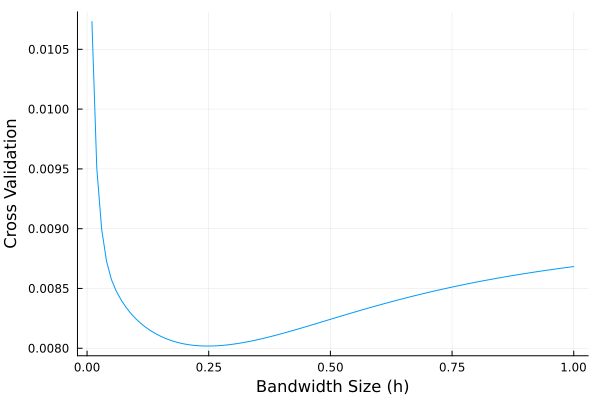

In [5]:
CVh     
#No strange repeated values, etc. It makes sense to me that these estimates should be pretty similar 
#(i.e., range in values is not very large, no huge outliers -- at least to the naked eye)

# Plotting CVh values vs h (bandwidth sizes)
plot(hgrid, CVh, legend = false, xlabel="Bandwidth Size (h)", ylabel="Cross Validation")

In [6]:
# We want to minimize the curve above -- I don't see why we can't just look at the index of the minimum

    # Out of curiosity -- the minimum itself
    minCVh = minimum(CVh)   # 0.008018231887139257

    # The actual entry we are interested in
    hgrid[argmin(CVh)]

0.25

##### Part (ii), Subpart (c)

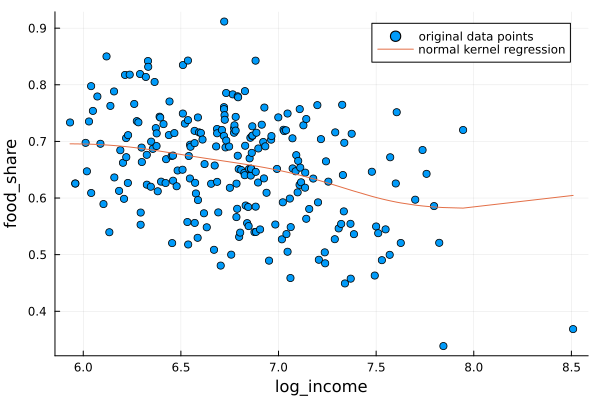

In [7]:
# Use the optimal bandwidth to estimate the Kernel Regression of share of food expenditures on log income at each value of X
# (X is the log income data) 

    # Re-using some of the code above
    # Note that we have set k = 25 (index of the optimal bandwidth value that we found above).
    # Eventually I should try to make this code even better by not repeating functions, etc.

    # No longer need to kick out a row, but we still need to loop over "x0" values.
    mhat = [0.0 for j in 1:N] # placeholder for our regression estimates at each point
    for j in 1:N 

        # Quick functions to calculate "z" inputs and their associated kernel
        function z_input(Xi,X0,h)
            (engel.log_income[Xi] - engel.log_income[X0])/hgrid[h] 
        end    

        function normal_kernel(z)
            K = (2π)^(-1/2) * exp.((-(z .^2) / 2))
        end
        
        # Now, we need to calculate the regression estimate. -  
        # It will use our new sample (will need to loop over "i's"), but will be evaluated AT the "kicked out" observation (j).

            # Calculate w_1 weight first:

                # Numerator:
                zn = [z_input(i,j,25) for i in 1:N-1]
                    #zn = z_input(1,1,1)  #first term in df1, we left out the first row, use first h entry
                wn = [normal_kernel(zn[i]) for i in 1:N-1]

                # Denominator (does not actually change as we move through Xi's!)
                    zd = [z_input(i,j,25) for i in 1:N-1]
                    Kd = [normal_kernel(zd[i]) for i in 1:N-1]
                    wd = sum(Kd)
                
                # Put together
                w = [wn[i]/wd for i in 1:N-1]

    # Mutiply with the associated outcome value (Y_i, food's share of income)
        wY = [w[i] * engel.food_share[i] for i in 1:N-1]

    # Sum over the wY terms
        mhat[j] = sum(wY)
    end

# Plot the estimated regression curve and a scatterplot of the data in the same graph.
a = plot(scatter(engel.log_income, engel.food_share, label = "original data points"))
b = plot(a, engel.log_income, mhat, labels = "normal kernel regression", xlabel="log_income", ylabel="food_share")

##### Part (iii) - Local Linear Regression

Estimate the regression of share of food expenditures on log income (i.e. the Engel curve) using Local Linear Regression with a normal kernel in three steps:
* (a) For Local Linear Regression, calculate and plot the cross-validation criterion as a function of h (the bandwidth) on the interval (1, 2] at 0.01 increments (e.g. h = 1.01, 1.02, . . . , 1.99, 2).
* (b) Approximate the optimal bandwidth hCV using a grid search over the interval (1, 2] in 0.01 increments.
* (c) Use the optimal bandwidth to estimate the Local Linear Regression of share of food expenditures on log income at each value of X, where X is the log income data. Plot the estimated regression curve and a scatterplot of the data in the same graph.

##### Part (iii), Subpart (a)
Formula for Cross Validation (see slide 12/23 in "Nonparametric Methods II" from Mikkel):

$$CV(h) = \frac{1}{N}\sum_{i=1}^N(Y_i - \hat{m}_{-i}(X_i))^2$$
    
* my assumption is that this time around, we want $\hat{m}_{-i}(X_i)$ to be the leave-i-out LOCAL LINEAR regression estimator of $m(X_i)$ (with bandwidth h).
    

In [14]:
# Suppose the weighted regression works like I think it should. 
# Then we would want to do a similar process as above with "leave one out"

# Create h values for use calculating cross-validation criterion
hgrid2 = collect(range(1.01, 2, step=0.01))

## FULL first iteration - with the goal of calculating the cross-validation criterion as a function of h.

# Iterating through each possible h in the grid

    # Placeholder vector to store each of the Cross Validation estimates
    CVh = [0.0 for k in 1:100]

    for k in 1:100  
        # This might take a long time when you first run it in Julia. 
        # If so, try the following:
            # Restart julia / your console    
            # lower the bound on this loop to 5, run it, and build back up to 100.
            
    # Running through all of the "leave one out" estimates

        # Placeholder vector to store each of these estimates
        mhat = [0.0 for j in 1:N]

        # Pull the sample / kick out a row:
        for j in 1:N
        df = engel[1:end .!= j,:] # will overwrite/create a new dataframe for us to use each iteration.

        # Run regression on this new dataframe, and evaluate AT the first row

            # Weights for the regression
            function z_input(Xi,X0,h)
                (df.log_income[Xi] - engel.log_income[X0])/hgrid2[h] 
                #notice that we are pulling observations from the new dataframe, but 
                #we are evaluating at the value that we left out (i.e., pulling from "Engel" at the "j" index)
            end    
            function normal_kernel(z)
                K = (2π)^(-1/2) * exp.((-(z .^2) / 2))
            end
            
            z = [z_input(i,j,k) for i in 1:N-1] 
                #z = z_input(1,1,1)  #first term in df1, we left out the first row, use first h entry
            w = [normal_kernel(z[i]) for i in 1:N-1]

            # The weighted regression itself
                wlr = linregress(df.log_income, df.food_share, w)

        # Obtain the predicted Y value based on this regression estimate AT the j index (X0)
            mhat[j] = coef(wlr)[2] .+ (coef(wlr)[1] .* engel.log_income[j])
        end

    # See formula above for CV(h)
    squared_error = (engel.food_share - mhat).^2
    CVh[k] = (1/N)*(sum(squared_error))
    end

##### Part (iii), Subpart (b)

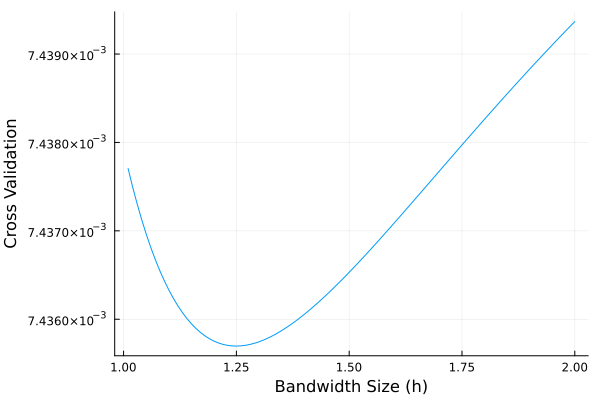

In [13]:
CVh     

# Plotting CVh values vs h (bandwidth sizes)
plot(hgrid2, CVh, legend = false, xlabel="Bandwidth Size (h)", ylabel="Cross Validation")

In [17]:
# As with part (ii) with the kernel regression, we just want to minimize the curve above

    # Out of curiosity -- the minimum itself
    minCVh = minimum(CVh)   # 0.007435696861093642

    # The actual entry we are interested in
    hgrid2[argmin(CVh)]      # should we be surprised it's the same bandwidth index as the previous part? That's interesting.

1.25

##### Part (iii), Subpart (c)

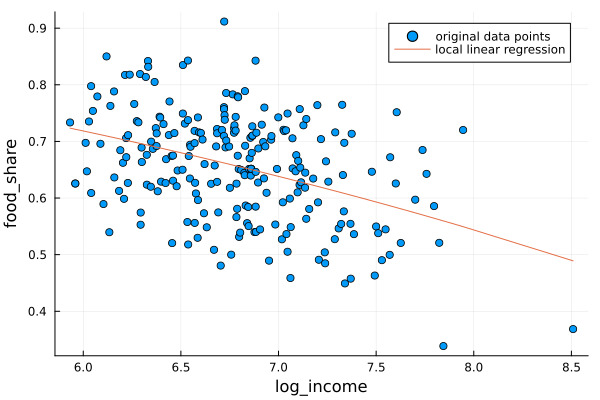

In [22]:
# Placeholder vector to store each of these estimates
mhat = [0.0 for j in 1:N]

# Iterating through all of the x0 points that we want estimates for
for j in 1:N

    # Run regression
    # Weights for the regression
    function z_input(Xi,X0,h)
        (engel.log_income[Xi] - engel.log_income[X0])/hgrid2[h] 
    end    
        #could make the above (using only engel's) a specific function! (and the one for the CVh's could be a different one)
    function normal_kernel(z)
        K = (2π)^(-1/2) * exp.((-(z .^2) / 2))
    end
    
    z = [z_input(i,j,25) for i in 1:N] 
        #z = z_input(1,1,1)  #first term in df1, we left out the first row, use first h entry
    w = [normal_kernel(z[i]) for i in 1:N]

    # The weighted regression itself
        wlr = linregress(engel.log_income, engel.food_share, w)

# Obtain the predicted Y value based on this regression estimate AT the j index (X0)
    mhat[j] = coef(wlr)[2] .+ (coef(wlr)[1] .* engel.log_income[j])
end

# Plot the estimated regression curve and a scatterplot of the data in the same graph.
a = plot(scatter(engel.log_income, engel.food_share, label = "original data points"))
b = plot(a, engel.log_income, mhat, labels = "local linear regression", xlabel="log_income", ylabel="food_share")

# Looks reasonable at least! But I guess I would have expected this to be a bit more curvy. Still need to compare with others.
# Looks almost identical to Cam's -- that's huge!

##### Part (iv) - Polynomial Series Regression

Estimate the regression of share of food expenditures on log income (i.e. the Engel curve) using Polynomial Series Regression in three steps:

* (a) For Polynomial Series Regression, calculate and plot the cross-validation criterion as a function of p (the order of the polynomial) on the grid {1, 2, . . . , 10}.
* (b) Select the polynomial order that minimizes the cross-validation criterion.
* (c) Use the optimal polynomial order to estimate the Polynomial Series Regression of share of food expenditures on log income at each value of X, where X is the log income data. Plot the estimated regression curve and a scatterplot of the data in the same graph.

In [86]:
# One important note that I realized after starting this code:
    # "polynomial series regression" is NOT "local polynomial regression"
    # So, there is no optimal *bandwidth* selection -- we are only optimally selecting the order "p"
    # Keep in mind that this means we will be doing analysis "globally" in this case
        # So observations that are "far" from each other will still have an influence on the regression estimates at that point.

# Recall that a polynomial regression can be coded as a linear regression that has variables to different powers as covariates
# (e.g., X^2, X^3, etc. will be "X variables")

# Create a new matrix of CV's to fill in
CVp = [0.0 for i in 1:10]

# matrix of X (log_income) raised to different powers
X_powers = zeros(N,10)
    for i in 1:N
        for j in 1:10
            X_powers[i,j] = engel.log_income[i]^j
        end 
    end

# note that in this case the "k's" are the different p-degrees (not bandwidth in this case)
for k in 1:10
    
    # Pull the sample / kick out a row:
    for j in 1:N
    df = X_powers[1:end .!= j,:] # will overwrite/create a new dataframe for us to use each iteration.
    df2 = engel[1:end .!= j,:]

    # Running our regression (another method to look into for future learning --> "optim.minimizer" function)
    lr = linregress(df[:, 1:k], df2.food_share) #notice that we aren't adding any weights to this one!

    # Predicted values of y (m-hat's in the notation from Mikkel's slides)
        # This is just matrix multiplication between the rows and the beta coefficients. Don't forget the intercepts!
        ones = [1.0 for i in 1:N]
        intercepts = ones .* coef(lr)[end,:]
        rest = X_powers[:, 1:k] * coef(lr)[1:k,:]
        mhat[j] =  intercepts[j] + rest[j] #notice that now we are back to using all observations
    end 
    # See formula above for CV(h)
    squared_error = (engel.food_share - mhat).^2
    CVp[k] = (1/N)*(sum(squared_error))
end

##### Part (iv), Subpart (b)

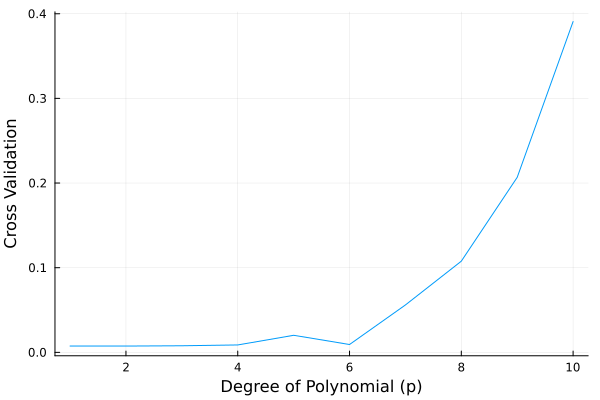

In [88]:
p = [1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0; 9.0; 10.0]  

# Plotting CVh values vs h (bandwidth sizes)
plot(p, CVp, legend = false, xlabel="Degree of Polynomial (p)", ylabel="Cross Validation")

# This curve looks a bit more reasonable now, but still needs confirmation

In [89]:
# As with part (ii) with the kernel regression, we just want to minimize the curve above

    # Out of curiosity -- the minimum itself
    minCVp = minimum(CVp)   # 0.007217071259422771

    # The actual entry we are interested in
    p[argmin(CVp)]      

2.0

##### Part (iii), Subpart (c)

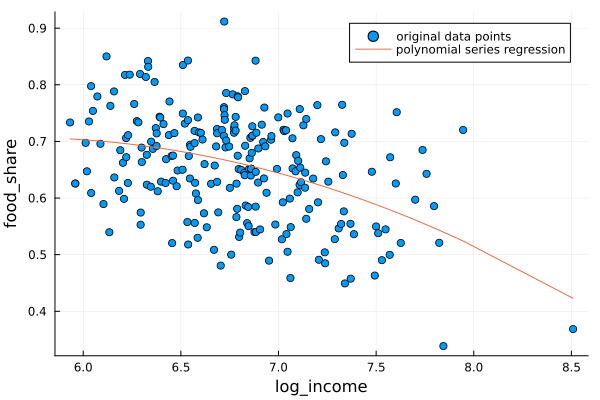

In [90]:
# Running our regression
lr = linregress(X_powers[:, 1:2], engel.food_share)

# Predicted values of y (m-hat's in the notation from Mikkel's slides)
    # This is just matrix multiplication between the rows and the beta coefficients.
    ones = [1.0 for i in 1:N]
    mhat = (ones .* coef(lr)[end,:]) + (X_powers[:, 1:2] * coef(lr)[1:2,:])

# Plot the estimated regression curve and a scatterplot of the data in the same graph.
a = plot(scatter(engel.log_income, engel.food_share, label = "original data points"))
b = plot(a, engel.log_income, mhat, labels = "polynomial series regression", xlabel="log_income", ylabel="food_share")

# Confirmed this shape with Cam